# **Bioinformatics Project - Computational Drug Discovery [Part 2] Exploratory Data Analysis**

Chanin Nantasenamat

[*'Data Professor' YouTube channel*](http://youtube.com/dataprofessor)

In this Jupyter notebook, we will be building a real-life **data science project** that you can include in your **data science portfolio**. Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Install conda and rdkit**

In [38]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2025-01-26 04:51:29--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’

Miniconda3-py37_4.8 100%[===================>]  81.12M   192MB/s    in 0.4s    

2025-01-26 04:51:30 (192 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh.1’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1

## **Load bioactivity data**

In [59]:
import pandas as pd

In [60]:
df = pd.read_csv('bioactivity_preprocessed_data.csv')

## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10

### **Import libraries**

In [61]:
!pip install rdkit

In [62]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [63]:
def is_valid_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None  # Returns True if valid, False otherwise
    except:
        return False

# Apply the function to create a 'valid_smiles' column
df['valid_smiles'] = df['canonical_smiles'].apply(is_valid_smiles)

# Filter the DataFrame to keep only rows with valid SMILES
df_cleaned = df[df['valid_smiles'] == True].drop('valid_smiles', axis=1)

# Save the cleaned dataset
df_cleaned.to_csv('bioactivity_cleaned_data.csv', index=False)


In [64]:
def standardize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            return Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
        else:
            return None  # Handle invalid SMILES
    except:
        return None  # Handle errors

df_cleaned['canonical_smiles'] = df_cleaned['canonical_smiles'].apply(standardize_smiles)

# Remove rows with None (invalid or unstandardized) SMILES
df_cleaned = df_cleaned.dropna(subset=['canonical_smiles'])

In [65]:
from rdkit.Chem import SaltRemover

remover = SaltRemover.SaltRemover()

def remove_salts(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            desalted_mol = remover.StripMol(mol)
            return Chem.MolToSmiles(desalted_mol)
        else:
            return None
    except:
        return None

df_cleaned['canonical_smiles'] = df_cleaned['canonical_smiles'].apply(remove_salts)
df_cleaned = df_cleaned.dropna(subset=['canonical_smiles'])

In [73]:
df_cleaned = df_cleaned.drop_duplicates(subset=['canonical_smiles'], keep='first')

In [80]:
df = pd.read_csv('bioactivity_cleaned_data.csv')

In [82]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors

In [76]:
df_lipinski = lipinski(df.canonical_smiles)

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [77]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,359.857,2.85810,1.0,4.0
1,329.831,2.84950,1.0,3.0
2,334.423,2.37620,1.0,4.0
3,354.841,2.72118,1.0,4.0
4,334.423,2.37620,1.0,4.0
...,...,...,...,...
397,418.493,4.50020,1.0,5.0
398,420.509,4.54340,1.0,5.0
399,418.493,4.50020,1.0,5.0
400,420.509,4.54340,1.0,5.0


In [70]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL49231,COc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,8.40,active
1,CHEMBL298763,O=C(NCN1CCN(c2ccccc2Cl)CC1)c1ccccc1,106.00,active
2,CHEMBL300956,Cc1ccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)cc1,1.20,active
3,CHEMBL49876,N#Cc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,3.90,active
4,CHEMBL45244,Cc1cccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)c1,17.00,active
...,...,...,...,...
397,CHEMBL5426242,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2ccc(=O)[nH]c2c...,1154.00,intermediate
398,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,288.40,active
399,CHEMBL5426242,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2ccc(=O)[nH]c2c...,954.99,active
400,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,288.40,active


Now, let's combine the 2 DataFrame

In [71]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [72]:
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL49231,COc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,8.40,active,359.857,2.85810,1.0,4.0
1,CHEMBL298763,O=C(NCN1CCN(c2ccccc2Cl)CC1)c1ccccc1,106.00,active,329.831,2.84950,1.0,3.0
2,CHEMBL300956,Cc1ccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)cc1,1.20,active,334.423,2.37620,1.0,4.0
3,CHEMBL49876,N#Cc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,3.90,active,354.841,2.72118,1.0,4.0
4,CHEMBL45244,Cc1cccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)c1,17.00,active,334.423,2.37620,1.0,4.0
...,...,...,...,...,...,...,...,...
397,CHEMBL5426242,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2ccc(=O)[nH]c2c...,1154.00,intermediate,418.493,4.50020,1.0,5.0
398,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,288.40,active,420.509,4.54340,1.0,5.0
399,CHEMBL5426242,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2ccc(=O)[nH]c2c...,954.99,active,418.493,4.50020,1.0,5.0
400,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,288.40,active,420.509,4.54340,1.0,5.0


In [84]:
df_cleaned = df_combined[df_combined['MW'] < 500]  # Example: keep molecules with MW < 500

### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [94]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pEC50(input):
                pEC50 = []
                for i in input['standard_value_norm']:
                    if i > 0:  # Check if value is positive
                        molar = i*(10**-9)
                        pEC50.append(-np.log10(molar))
                    else:
                        pEC50.append(np.nan) # Or handle it differently
                input['pEC50'] = pEC50
                x = input.drop('standard_value_norm', axis=1)
                return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [95]:
df_combined.standard_value.describe()

,standard_value
count,402.000000
mean,1563.303830
std,8356.355963
min,0.000000
25%,13.675000
50%,52.000000
75%,288.400000
max,100000.000000


In [96]:
-np.log10( (10**-9)* 100000000 )

1.0

In [97]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [98]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1) # Changed this line to use axis=1

    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [99]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL49231,COc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,active,359.857,2.85810,1.0,4.0,8.40
1,CHEMBL298763,O=C(NCN1CCN(c2ccccc2Cl)CC1)c1ccccc1,active,329.831,2.84950,1.0,3.0,106.00
2,CHEMBL300956,Cc1ccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)cc1,active,334.423,2.37620,1.0,4.0,1.20
3,CHEMBL49876,N#Cc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,active,354.841,2.72118,1.0,4.0,3.90
4,CHEMBL45244,Cc1cccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)c1,active,334.423,2.37620,1.0,4.0,17.00
...,...,...,...,...,...,...,...,...
397,CHEMBL5426242,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2ccc(=O)[nH]c2c...,intermediate,418.493,4.50020,1.0,5.0,1154.00
398,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,active,420.509,4.54340,1.0,5.0,288.40
399,CHEMBL5426242,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2ccc(=O)[nH]c2c...,active,418.493,4.50020,1.0,5.0,954.99
400,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,active,420.509,4.54340,1.0,5.0,288.40


In [100]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,402.000000
mean,1563.303830
std,8356.355963
min,0.000000
25%,13.675000
50%,52.000000
75%,288.400000
max,100000.000000


In [101]:
df_final = pEC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pEC50
0,CHEMBL49231,COc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,active,359.857,2.85810,1.0,4.0,8.075721
1,CHEMBL298763,O=C(NCN1CCN(c2ccccc2Cl)CC1)c1ccccc1,active,329.831,2.84950,1.0,3.0,6.974694
2,CHEMBL300956,Cc1ccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)cc1,active,334.423,2.37620,1.0,4.0,8.920819
3,CHEMBL49876,N#Cc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,active,354.841,2.72118,1.0,4.0,8.408935
4,CHEMBL45244,Cc1cccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)c1,active,334.423,2.37620,1.0,4.0,7.769551
...,...,...,...,...,...,...,...,...
397,CHEMBL5426242,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2ccc(=O)[nH]c2c...,intermediate,418.493,4.50020,1.0,5.0,5.937794
398,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,active,420.509,4.54340,1.0,5.0,6.540005
399,CHEMBL5426242,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2ccc(=O)[nH]c2c...,active,418.493,4.50020,1.0,5.0,6.020001
400,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,active,420.509,4.54340,1.0,5.0,6.540005


In [102]:
df_final.pEC50.describe()

,pEC50
count,401.000000
mean,7.151673
std,1.027337
min,4.000000
25%,6.540005
50%,7.283997
75%,7.856985
max,9.799971


### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [103]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pEC50
0,CHEMBL49231,COc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,active,359.857,2.85810,1.0,4.0,8.075721
1,CHEMBL298763,O=C(NCN1CCN(c2ccccc2Cl)CC1)c1ccccc1,active,329.831,2.84950,1.0,3.0,6.974694
2,CHEMBL300956,Cc1ccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)cc1,active,334.423,2.37620,1.0,4.0,8.920819
3,CHEMBL49876,N#Cc1ccccc1N1CCN(CNC(=O)c2ccc(Cl)cc2)CC1,active,354.841,2.72118,1.0,4.0,8.408935
4,CHEMBL45244,Cc1cccc(C(=O)NCN2CCN(c3ccccc3C#N)CC2)c1,active,334.423,2.37620,1.0,4.0,7.769551
...,...,...,...,...,...,...,...,...
393,CHEMBL5403204,COc1ccc(-c2ccccc2)c(CNC(=O)NCCCN2CCN(c3ccccc3O...,active,488.632,4.38230,2.0,5.0,6.119186
398,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,active,420.509,4.54340,1.0,5.0,6.540005
399,CHEMBL5426242,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2ccc(=O)[nH]c2c...,active,418.493,4.50020,1.0,5.0,6.020001
400,CHEMBL5409419,COc1cccc2c3c(oc12)CN(CCCCOc1ccc2c(c1)NC(=O)CC2...,active,420.509,4.54340,1.0,5.0,6.540005


---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [104]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

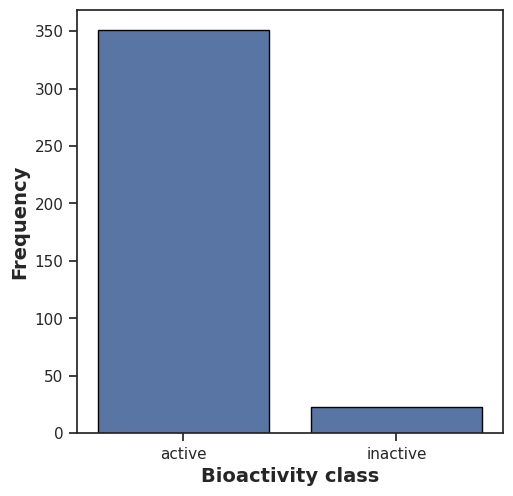

In [105]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

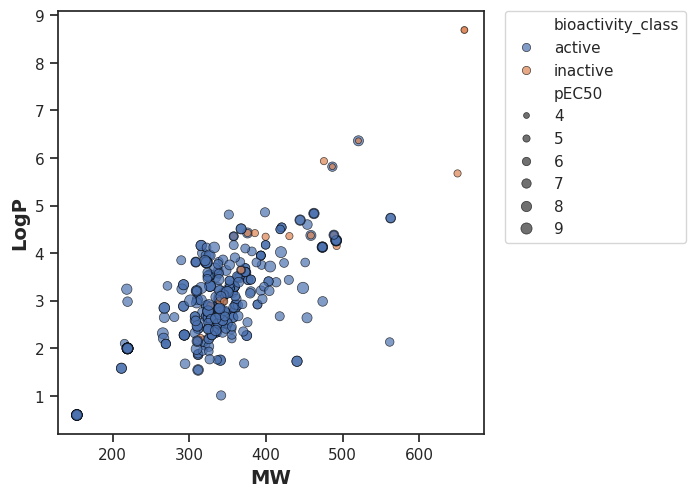

In [107]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pEC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

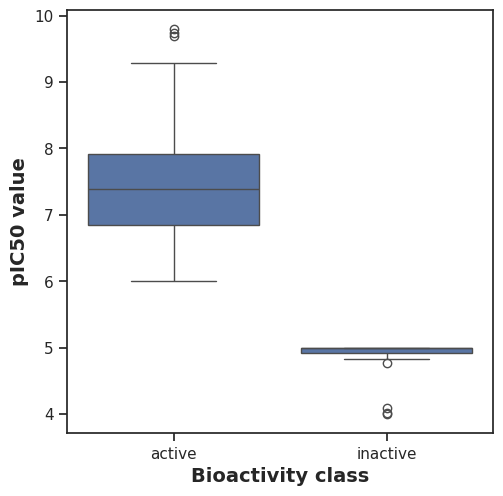

In [109]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pEC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [110]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [111]:
mannwhitney('pEC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pEC50,NaN,NaN,0.05,Different distribution (reject H0)


#### **MW**

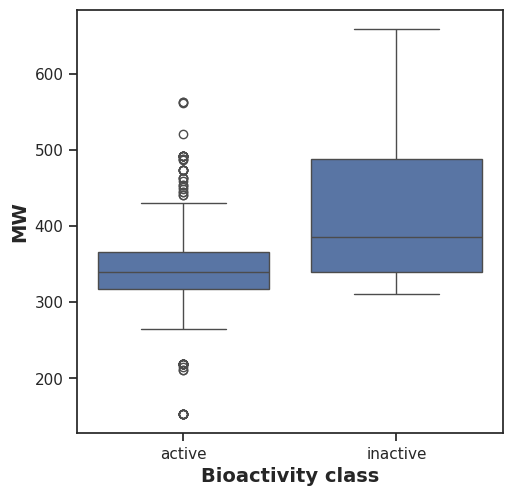

In [112]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [113]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,2120.5,0.000137,0.05,Different distribution (reject H0)


#### **LogP**

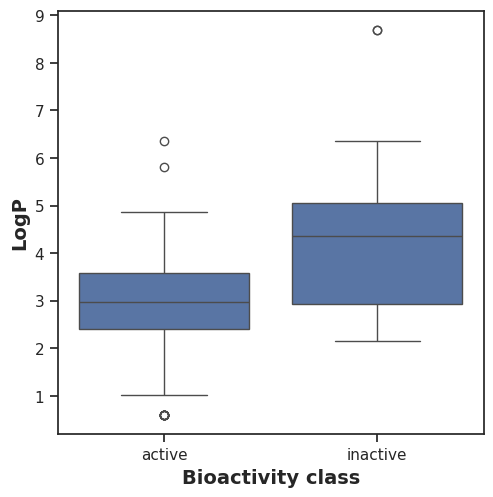

In [114]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [115]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2007.0,0.000053,0.05,Different distribution (reject H0)


#### **NumHDonors**

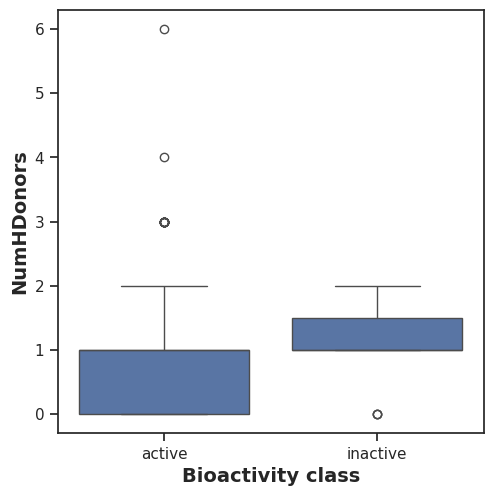

In [116]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [117]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,3476.0,0.215835,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

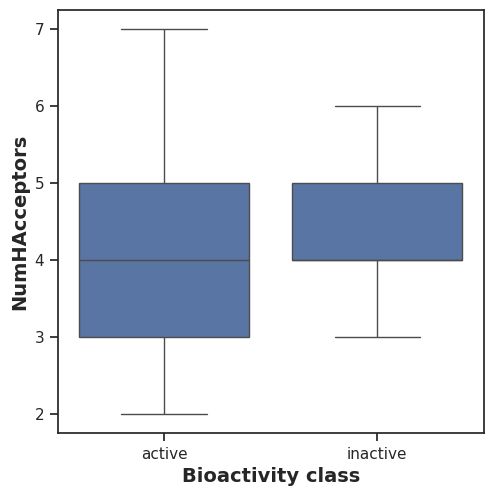

In [118]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [119]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,3681.5,0.465546,0.05,Same distribution (fail to reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited ***no difference*** between the **actives** and **inactives** while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows ***statistically significant difference*** between **actives** and **inactives**.

## **Zip files**

In [120]:
! zip -r results.zip . -i *.csv *.pdf

  adding: bioactivity_preprocessed_data.csv (deflated 82%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: plot_MW.pdf (deflated 37%)
  adding: mannwhitneyu_MW.csv (deflated 9%)
  adding: plot_NumHAcceptors.pdf (deflated 38%)
  adding: mannwhitneyu_pEC50.csv (deflated 9%)
  adding: plot_MW_vs_LogP.pdf (deflated 7%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: mannwhitneyu_NumHAcceptors.csv (deflated 10%)
  adding: plot_NumHDonors.pdf (deflated 38%)
  adding: mannwhitneyu_LogP.csv (deflated 9%)
  adding: bioactivity_cleaned_data.csv (deflated 82%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: plot_LogP.pdf (deflated 37%)


In [121]:
df_2class.to_csv('df_2class.csv', index=False)
# index=False prevents the DataFrame index from being written to the file

from IPython.display import FileLink
FileLink('df_2class.csv')

/content/df_2class.csv